# CALCUL WATER MASSES TRANSPORT

In [2]:
import numpy as N
np=N
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dask
from os import path
from dask.distributed import Client, LocalCluster, progress
import dask_hpcconfig
import glob
from scipy import signal
from dask_jobqueue import PBSCluster
import seawater as sw
import numba
from tools import my_zr_ufunc,water_masses_transport3



### set Cluster for dask : On utilise PBS

In [5]:
#PBS
#processes = nombre par lequel on divise le nombre de procs dispo sur le noeud : si 4 alors il y aura 7 process
#cores= nombre de threads au total => nthreads_per_worker = ncores/processes 
#si cores=processes alors 1 thread par worker
#si on veut plus de memoire par process on diminue son nombre

#pour datarmor il faut 1 seul thread par worker quand on fait bcp de IO
cluster = PBSCluster(processes=2,cores=2) 


cluster.scale(jobs=3)

/home1/datahome/mcaillau/conda-env/pydask3/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mcaillau/conda-env/pydask3/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mcaillau/conda-env/pydask3/l

In [6]:
cluster.job_script()

/home1/datahome/mcaillau/conda-env/pydask3/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mcaillau/conda-env/pydask3/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


'#!/usr/bin/env bash\n\n#PBS -N dask-worker\n#PBS -q mpi_1\n#PBS -A myPROJ\n#PBS -l select=1:ncpus=28:mem=120GB\n#PBS -l walltime=04:00:00\n#PBS -m n\n\n/home1/datahome/mcaillau/conda-env/pydask3/bin/python -m distributed.cli.dask_worker tcp://10.148.0.24:52839 --nthreads 1 --nworkers 2 --memory-limit 55.88GiB --name dummy-name --nanny --death-timeout 900 --local-directory $TMPDIR --interface ib0\n'

In [7]:
# connect the client to the cluster

print(cluster.dashboard_link)
# explicitly connect to the cluster we just created
client = Client(cluster)
print(client)


http://10.148.0.24:8787/status
<Client: 'tcp://10.148.0.24:52839' processes=0 threads=0, memory=0 B>


### Select only a part of the domain

In [8]:
#set bounds to reduce area to western bassin
xi_bnds,eta_bnds=(420,1026),(350,860)


In [9]:
#read grid
ds_grid=xr.open_dataset('/home/shom_simuref/CROCO/ODC/CONFIGS/MEDITERRANEE_GLOBALE/CROCO_FILES/test2.nc')
ds_grid=ds_grid.isel(xi_rho=slice(*xi_bnds), eta_rho=slice(*eta_bnds),
                      xi_u=slice(*xi_bnds),eta_v=slice(*eta_bnds))

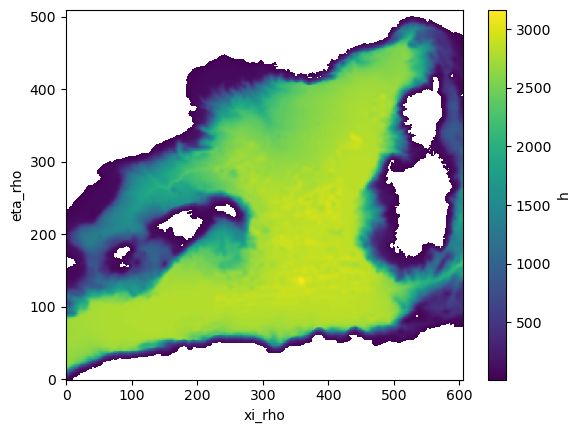

In [10]:
#control plot
h=ds_grid.h.where(ds_grid.h>11)
h.plot()

### DATA PATH AND CHUNKS

In [12]:
path="/home/shom_simuref/CROCO/ODC/SIMU-RESULT/HINDCAST_2012_2013/OUTPUTS_201207_201307/"

In [13]:
list_model=glob.glob(path+"croco_his_2*.nc")

In [14]:
chunks={'time':8,'s_rho':-1,'xi_rho':865,'eta_rho':936,"xi_u":1297,"eta_v":935} #chunks sans preprocess


#### FUNCTION TO RESTRICT THE READ OF DATA TO WESTERN BASIN

In [15]:
from functools import partial
def _preprocess(x, xi_bnds, eta_bnds):
        return x.isel(xi_rho=slice(*xi_bnds), eta_rho=slice(*eta_bnds),
                      xi_u=slice(*xi_bnds),eta_v=slice(*eta_bnds))

partial_func = partial(_preprocess,xi_bnds=xi_bnds,eta_bnds=eta_bnds)

### READ THE DATA

In [16]:
ds=xr.open_mfdataset(list_model, parallel=False,chunks="auto",
                        concat_dim="time", combine="nested",
                        preprocess=partial_func,data_vars='minimal', coords='minimal', compat='override')
                       # data_vars='minimal', coords='minimal', compat='override')

print('data size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))


data size in GB 58.35



In [17]:
#chunk the data
ds=ds.chunk(chunks)

#### assign grid to the dataset because of MPI_NOLAND grid is not complete in the netcdf files

In [18]:
for var in ["xi_rho","eta_rho","lon_rho","lat_rho","lon_u","lat_v","mask_rho","pm","pn"]:
    ds[var]=ds_grid[var]

In [19]:
coords=list(ds.coords)
variables=list(ds.variables)
to_keep=["temp","salt","u","v","zeta","h"]
var=[x for x in variables if x not in coords and x not in to_keep]

In [22]:
#ds2=ds.drop(var)
ds2=ds

### Change of coordinates for interpolation and plot

In [23]:
coord_dict={"xi_rho":"X","eta_rho":"Y","xi_u":"X_U","eta_v":"Y_V"}
ds2=ds2.assign_coords({"X":ds.lon_rho[0,:], "Y":ds.lat_rho[:,0],"X_U":ds.lon_u[0,:],"Y_V":ds.lat_v[:,0]})
ds3=ds2.swap_dims(coord_dict)

### Interpolation of current speed on meshes center (rho-point)

In [24]:
ds3["u_rho"]=ds3.u.interp(X_U=ds3.X,Y=ds3.Y)
ds3["v_rho"]=ds3.v.interp(X=ds3.X,Y_V=ds3.Y)

In [25]:
ds3=ds3.drop(["u","v","xi_rho","eta_rho","lon_rho","lat_rho","xi_u","eta_v","lon_u","lat_v"])

### calcul of depths (will be used to compute the transport)

#### get all the grid parameters

In [27]:
h,hc,sc,cs=ds3.h,ds3.hc,ds3.s_w,ds3.Cs_w

h=h.where(ds3.mask_rho==1)

sc=sc.rename({'s_w':'s_rho'})
cs=cs.rename({'s_w':'s_rho'})

dx,dy=1/ds3.pm,1/ds3.pn
dx=dx.compute()
dy=dy.compute()
hinv=1/(h+hc)

#### calcul of depth from sigma levels

In [28]:
zw=my_zr_ufunc(ds3.zeta,h,hinv,hc,sc,cs)
zw=zw.rename({'s_rho':'s_w'})

In [29]:
zw=zw.transpose("time","s_w","Y","X")

### Calcul of water masses fractions

#### Calcul of water density from T,S

In [30]:
tt=ds3["temp"]
ss=ds3["salt"]
ss=ss.where(ds3.mask_rho==1)
tt=tt.where(ds3.mask_rho==1)

In [31]:
def density(sal,temp):
 # x ...... xr data array
 # dims .... dimension aong which to apply function    
 dens= xr.apply_ufunc(
     sw.dens0,  # first the function
     sal,# now arguments in the order expected by 'butter_filt'
     temp,  # argument 1
     vectorize=False,  # loop over non-core dims
     dask="parallelized",
     output_dtypes=[sal.dtype],
     )

 return dens-1000.

In [32]:
%%time
rr=density(ss,tt)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.32 ms


#### First step in the calcul of fractions : references coordinates of water masses (defined by theta, S and density)


In [41]:
# nAW
s_naw = 36.000; t_naw = 16.000; r_naw = sw.dens0(s_naw,t_naw)-1000;
# mAW
s_maw = 38.450; t_maw = 13.500; r_maw = sw.dens0(s_maw,t_maw)-1000;
# WIW
t_wiw = 13.000; s_wiw = 38.325; r_wiw = sw.dens0(s_maw,t_maw)-1000;
# LIW
s_liw = 39.000; t_liw = 15.000; r_liw = sw.dens0(s_liw,t_liw)-1000;
# WMDW
s_mdw = 38.450; t_mdw = 12.815; r_mdw = sw.dens0(s_mdw,t_mdw)-1000;


#### Second step in the calcul of fractions : the following function compute the differents fractions from the references coordinates

In [42]:
def calc_frac(tt,ss,rr):
    
    #Fractions de mélange entre les masses d'eau

    xr1 = (r_liw-rr)/(r_liw-r_maw)          # xr1 (maw)   1-xr1 (liw)
    xr2 = (rr-r_liw)/(r_mdw-r_liw)          # xr2 (mdw)   1-xr2 (liw)

    xs1 = (s_naw-ss)/s_naw                  # xs1 (frw)   1-xs1 (naw)
    xs2 = (s_maw-ss)/(s_maw-s_naw)          # xs2 (naw)   1-xs2 (maw)
    xs3 = (ss-s_maw)/(s_liw-s_maw)          # xs3 (liw)   1-xs3 (maw)

    xt1 = (tt-t_wiw)/(t_maw-t_wiw)          # xt1 (maw)   1-xt1 (wiw)
    
    # Tri des masses d'eau (pour détails et explication, se référer à l'annexe A du GDoc de l'article n°2 :
    # "Assessment of the water mass dynamics over the Western Mediterranean in the MEDRYS1V2 reanalysis"

    #surface mask
    tmp_surf=N.where((rr <= r_liw), xr1, 0.0)
    f_surf=N.where(tmp_surf >=1, 1.0, tmp_surf)

    #deep mask
    tmp_deep=N.where(( rr>= r_liw),xr2,0.0)
    f_deep=N.where(tmp_deep>=1.,1.,tmp_deep)

    #frw
    f_fre=N.where(ss<=s_naw,xs1,0.0)

    #naw
    tmp_naw=N.where(ss<=s_maw,xs2,0.0)
    f_naw=N.where(tmp_naw>=1.,(1.-f_fre)*f_surf,tmp_naw*f_surf)

    #LIW
    f_liw0=N.where(xs3<0.,0.,xs3)
    tmp=f_fre+f_naw+f_liw0
    
    #WIW & mAW
    tmp_wiw=N.where((rr<r_liw) & (tt<=t_maw),1.-xt1,0.)
    rat_wiw=N.where((rr<r_liw) &(tmp_wiw>1.),1.,tmp_wiw)

    f_wiw=(1.-tmp)*f_surf*rat_wiw
    f_maw0=(1.-tmp)*f_surf*(1.-rat_wiw)

    #WMDW
    f_mdw=f_deep*(1.-tmp)

    #mIW
    f_in0=f_fre+f_naw+f_maw0+f_wiw+f_liw0+f_mdw
    f_miw0=1.-f_in0

    #1st correction (too high SSS)
    f_liw=N.where(((ss>s_maw) & (f_liw0>0.)) & ((tt>t_liw) | (rr<28.8)),0.0,f_liw0)
    f_maw=N.where(((ss>s_maw) & (f_liw0>0.)) & ((tt>t_liw) | (rr<28.8)),f_maw0+f_liw0,f_maw0)

    #2nd correction (machine error )
    f_miw=N.where((f_miw0<0.)| ( (f_miw0 !=0.) & (f_miw0<1e-10)),0.,f_miw0)

    return f_naw,f_wiw,f_mdw,f_liw,f_maw,f_miw

#### The following function is just a wrapper for having outputs in Xarray format. It also managed parallelization with apply_ufunc

In [43]:
def calc_frac_ufunc(temp,sal,dens):
 # x ...... xr data array
 # dims .... dimension aong which to apply function    
 f_naw,f_wiw,f_mdw,f_liw,f_maw,f_miw= xr.apply_ufunc(
             calc_frac,  # first the function
             temp,# now arguments in the order expected by 'butter_filt'
             sal,  # argument 1
             dens,
             vectorize=False,  # loop over non-core dims
             dask="parallelized",
             #input_core_dims=[ [], [],[]],
             output_core_dims=[ [],[],[],[],[],[]], # 1 per output
             #exclude_dims=set(("s_rho","eta_rho","xi_rho")),
             #output_dtypes=[sal.dtype],
         )

 return f_naw,f_wiw,f_mdw,f_liw,f_maw,f_miw

#### Calcul of fractions

In [44]:
%%time
f_naw,f_wiw,f_mdw,f_liw,f_maw,f_miw=calc_frac_ufunc(tt,ss,rr)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 9.65 ms


### List of waters 

In [70]:
waters=["naw","wiw","mdw","liw","maw","miw"]
water=waters[0]
out_path="/home/shom_simuref/CROCO/ODC/POSTPROC/MASSES_EAU/"


## Calcul of transport and volume

 split_job_time is a function that split the calcul in several groups of time indexes to be more efficient
 
The vertically integrated transport (of u and v) and the volume for a given water masse (defined by its fraction) are computed in water_masses_transport3 function from tools.This is the core of the calcul and it returns a Dataset with the 3 dataArrays (u_transport,v_transport, volume)

Once each sub-time groups are computed, they are concatenated in a single Xarray Dataset

In [52]:
def split_job_time(time_indexes,frac):
    trans_list=[]
    #loop over sub-time groups
    for ids in time_indexes:
        print(ids)
        #select data on theses indexes
        ds4=ds3.isel(time=ids)
        zw2=zw.isel(time=ids)
        frac2=frac.isel(time=ids)
        #compute of transport and volume
        transport=water_masses_transport3(ds4.u_rho,ds4.v_rho,zw2,frac2,dx,dy)
        #put the results in a list
        trans_list.append(transport.compute())
    #return a single dataset (concatenation of the list)
    return xr.concat(trans_list,dim="time")

#### Here we split the total time indexes in 15 sub groups (15 is a user choice)

In [53]:
time_indexes=N.array_split(N.arange(zw.shape[0]),15)
print(time_indexes)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]), array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59]), array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69]), array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]), array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]), array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109]), array([110, 111, 112, 113, 114, 115, 116, 117, 118, 119]), array([120, 121, 122, 123, 124, 125, 126, 127, 128]), array([129, 130, 131, 132, 133, 134, 135, 136, 137]), array([138, 139, 140, 141, 142, 143, 144, 145, 146])]


### Core of the script : here is the loop over waters masses 

It returns and write a Netcdf file for each water containing the transport along u and v and the fraction of the volume of the water per time step

In [51]:
%%time
for water in waters:
  print(water)
  frac=eval(f'f_{water}')
  transport=split_job_time(time_indexes[0:1],frac)
  transport=transport.sortby("time")
  with dask.config.set(scheduler='processes'):
    transport.to_netcdf(f'{out_path}/{water}.nc')

NameError: name 'waters' is not defined

## DEBUG AND TESTS ONLY

In [71]:
"""
%%time
ids=slice(10,15)
ds4=ds3.isel(time=ids).compute()
zw2=zw.isel(time=ids).compute()
frac2=f_naw.isel(time=ids).compute()
"""

'\n%%time\nids=slice(10,15)\nds4=ds3.isel(time=ids).compute()\nzw2=zw.isel(time=ids).compute()\nfrac2=f_naw.isel(time=ids).compute()\n'

In [72]:
"""
u=ds4.u_rho.transpose('time','Y','X','s_rho')
v=ds4.v_rho.transpose('time','Y','X','s_rho')
zw=zw2.transpose('time','Y','X','s_w')
fraction=frac2.transpose('time','Y','X','s_rho')
u=u.where(u<100)
v=v.where(v<100)
"""

"\nu=ds4.u_rho.transpose('time','Y','X','s_rho')\nv=ds4.v_rho.transpose('time','Y','X','s_rho')\nzw=zw2.transpose('time','Y','X','s_w')\nfraction=frac2.transpose('time','Y','X','s_rho')\nu=u.where(u<100)\nv=v.where(v<100)\n"

In [73]:
"""
from tools import water_masses_trans3
transu,transv,vol=[],[],[]
transu,transv,vol=water_masses_trans3(u.data,v.data,zw.data,fraction.data,dx.data,dy.data)
"""

'\nfrom tools import water_masses_trans3\ntransu,transv,vol=[],[],[]\ntransu,transv,vol=water_masses_trans3(u.data,v.data,zw.data,fraction.data,dx.data,dy.data)\n'

In [74]:
"""
test= xr.apply_ufunc(
        water_masses_trans3,  # first the function
        u,v, # then the arguments without the last which is the result
        zw,fraction,dx,dy,
        input_core_dims=[ ["s_rho"],["s_rho"], ["s_w"],["s_rho"],[],[]],
        dask="parallelized",
        #vectorize=True,
        output_dtypes=[u.dtype,u.dtype,u.dtype],
        output_core_dims=[[],[],[]],
     )
 """

'\ntest= xr.apply_ufunc(\n        water_masses_trans3,  # first the function\n        u,v, # then the arguments without the last which is the result\n        zw,fraction,dx,dy,\n        input_core_dims=[ ["s_rho"],["s_rho"], ["s_w"],["s_rho"],[],[]],\n        dask="parallelized",\n        #vectorize=True,\n        output_dtypes=[u.dtype,u.dtype,u.dtype],\n        output_core_dims=[[],[],[]],\n     )\n '

In [75]:
#transport=water_masses_transport3(ds4.u_rho,ds4.v_rho,zw2,frac2,dx,dy)

In [79]:
"""
ids=time_indexes[0]
ds4=ds3.isel(time=ids)
zw2=zw.isel(time=ids)
frac2=frac.isel(time=ids)
"""

'\nids=time_indexes[0]\nds4=ds3.isel(time=ids)\nzw2=zw.isel(time=ids)\nfrac2=frac.isel(time=ids)\n'

In [80]:
#transport=water_masses_transport3(ds4.u_rho,ds4.v_rho,zw2,frac2,dx,dy)

In [ ]:
ss=ss.isel(time=time_indexes[-1])
tt=tt.isel(time=time_indexes[-1])
rr=rr.isel(time=time_indexes[-1])
xr1 = (r_liw-rr)/(r_liw-r_maw)          # xr1 (maw)   1-xr1 (liw)
#xr2 = (rr-r_liw)/(r_mdw-r_liw)          # xr2 (mdw)   1-xr2 (liw)
xs3 = (ss-s_maw)/(s_liw-s_maw)   
#surface mask
tmp_surf=N.where((rr <= r_liw), xr1, 0.0)
f_surf=N.where(tmp_surf >=1, 1.0, tmp_surf)

#deep mask
#tmp_deep=N.where(( rr>= r_liw),xr2,0.0)
#f_deep=N.where(tmp_deep>=1.,1.,tmp_deep)

xs1 = (s_naw-ss)/s_naw  
xs2 = (s_maw-ss)/(s_maw-s_naw) 
f_fre=N.where(ss<=s_naw,xs1,0.0)
tmp_naw=N.where(ss<=s_maw,xs2,0.0)
f_naw=N.where(tmp_naw>=1.,(1.-f_fre)*f_surf,tmp_naw*f_surf)
#LIW
f_liw0=N.where(xs3<0.,0.,xs3)
tmp=f_fre+f_naw+f_liw0
#f_mdw=f_deep*(1.-tmp)

In [ ]:
mask=N.nanmean(tmp,axis=(0,1,))

/dev/shm/pbs.3670435.datarmor0/ipykernel_29392/2111236053.py:1: RuntimeWarning: Mean of empty slice
  mask=N.nanmean(tmp,axis=(0,1,))


In [ ]:
N.nanmax(mask)

3.7475507

In [ ]:
mask2=N.where((mask<1) | (ds3.mask_rho==0),np.nan,1)

In [40]:
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature

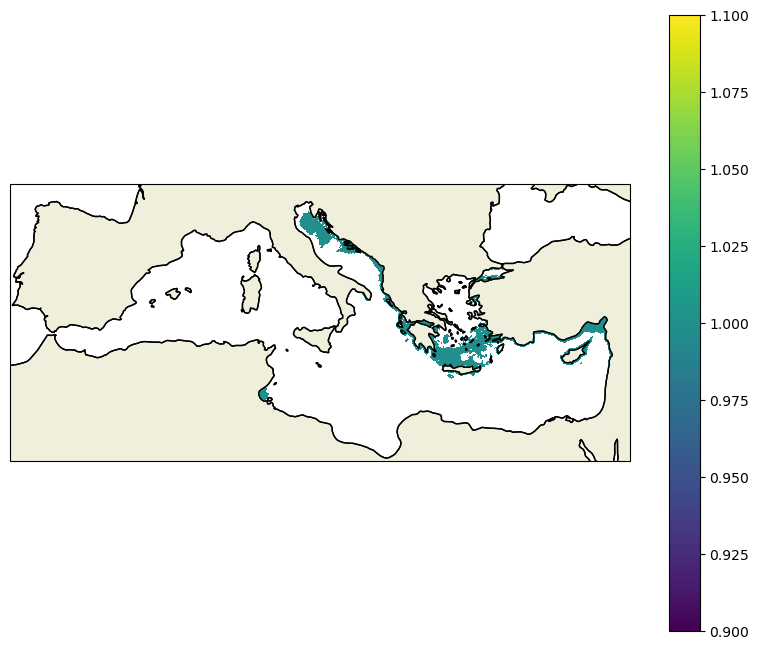

In [41]:
proj=ccrs.LambertConformal(central_latitude=38,central_longitude=15)
lon=ds_grid.lon_rho
lat=ds_grid.lat_rho
fig,ax=plt.subplots(1,1,figsize=(10,8),subplot_kw=dict(projection=proj))
ax.set_extent([-7,36,30,45],crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
cf=ax.pcolormesh(lon,lat,mask2.data,transform=ccrs.PlateCarree())
col=fig.colorbar(cf)